# Firing rate frequency filtering of candidate SOM models

Working hypothesis ws that burst firing vs. delayed firing SOM neurons might be responsible for integrating high vs. low frequency inputs. Since the CaGIF and KGIF are expected to capture these firing patterns, we can get a rough test of this hypothesis just by playing with the models.

As of 2019.03.18, CaGIF exhibits low latency to a first spike in response to a square input pulse. However, $I_T$ doesn't appear to change how noisy, in vivo-like inputs are integrated in any clear measurable way.

## Import modules

In [1]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..', '..'))
print os.getcwd()

/Users/eharkin/Documents/School/Grad work/Thesis/Experiments/GIF fitting/GIF fitting project/GIFFittingToolbox


In [2]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from scipy.signal import csd

from grr.GIF import GIF
from grr.CalciumGIF import CalciumGIF
from grr.AugmentedGIF import AugmentedGIF
from grr.Filter_Exps import Filter_Exps
from grr.Tools import gagProcess, generateOUprocess, timeToIntVec
from grr import pltools

%config InlineBackend.figure_format ='retina'

## Generate and inspect models

I'll use a vanilla GIF (null model), CaGIF (burst firing candidate model), and KGIF (delayed firing candidate model). The models instantiated here are all identical except for their active conductances. The spike-triggered filters are tweaked by eye to resemble what is seen in SOM neurons.

GIF 
-------------------------
GIF model parameters:
-------------------------
tau_m (ms):	60.000
R (MOhm):	1000.000
C (nF):		0.060
gl (nS):	0.001000
El (mV):	-65.000
Tref (ms):	4.000
Vr (mV):	-50.000
Vt* (mV):	-48.000
DV (mV):	2.000
-------------------------



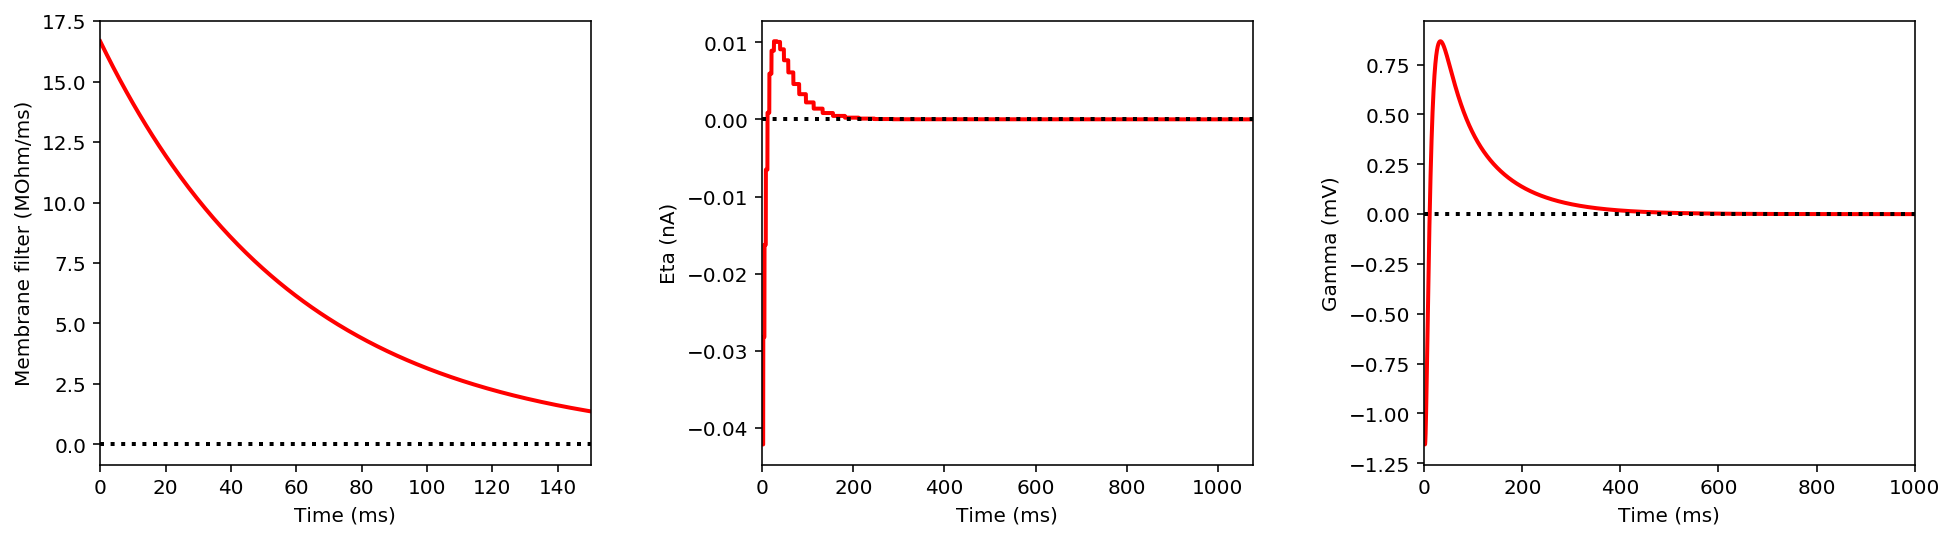

KGIF 
-------------------------
GIF model parameters:
-------------------------
tau_m (ms):	60.000
R (MOhm):	1000.000
C (nF):		0.060
gl (nS):	0.001000
El (mV):	-65.000
Tref (ms):	4.000
Vr (mV):	-50.000
Vt* (mV):	-48.000
DV (mV):	2.000
gk1 (ns):	0.0100
gk2 (ns):	0.0020
-------------------------



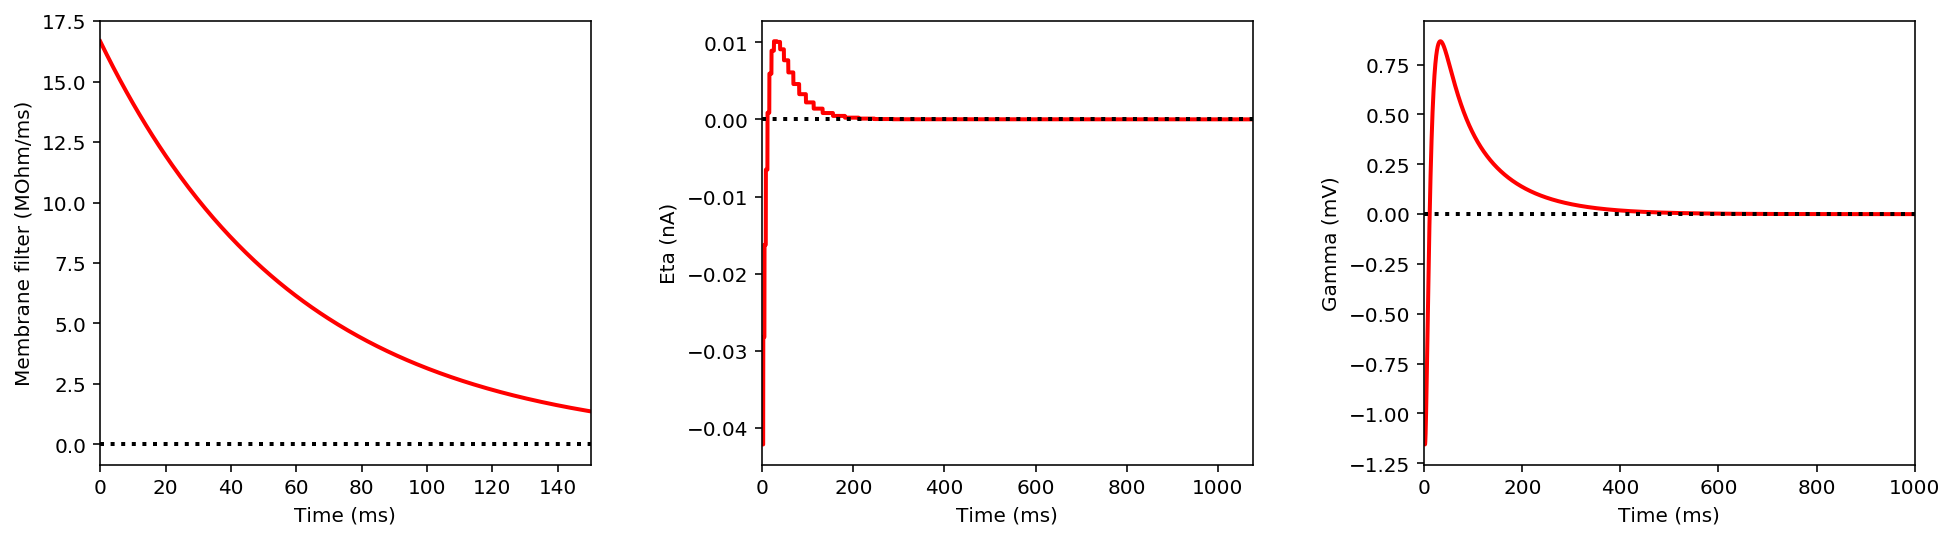

CaGIF 
-------------------------
GIF model parameters:
-------------------------
tau_m (ms):	60.000
R (MOhm):	1000.000
C (nF):		0.060
gl (nS):	0.001000
El (mV):	-65.000
Tref (ms):	4.000
Vr (mV):	-50.000
Vt* (mV):	-48.000
DV (mV):	2.000
gk1 (ns):	0.0050
gk2 (ns):	0.0020
-------------------------



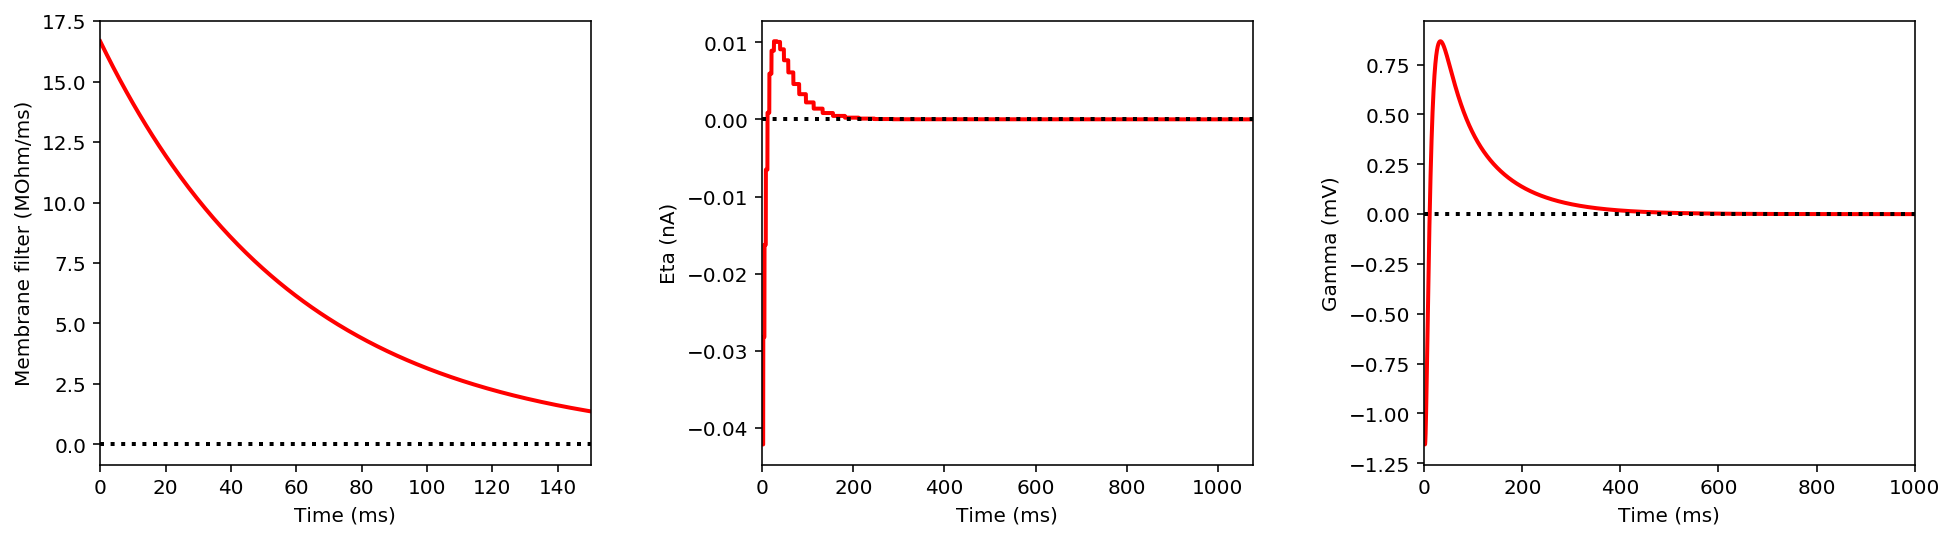

In [3]:
dt = 0.1

mods = {
    'GIF': GIF(dt),
    'CaGIF': CalciumGIF(dt),
    'KGIF': AugmentedGIF(dt)
}

## Set model specific parameters.
mods['KGIF'].gbar_K1 = 0.010
mods['KGIF'].gbar_K2 = 0.002
mods['KGIF'].n_tau = 1.

mods['CaGIF'].gbar_K1 = 0.005
mods['CaGIF'].gbar_K2 = 0.002
mods['CaGIF'].n_tau = 1.

## Set parameters that are common to all models.
def expfunction_eta(x):
    return -0.08*np.exp(-x/10.0) + 0.03 * np.exp(-x/40.)

for key in mods.keys():
    
    # Set spike-triggered filters.
    mods[key].eta.setFilter_Function(expfunction_eta)
    
    mods[key].gamma = Filter_Exps()
    mods[key].gamma.setFilter_Timescales([3., 10., 30., 100.])
    mods[key].gamma.setFilter_Coefficients([2., -5., 1., 1.])
    
    # Other firing parameters.
    mods[key].DV = 2.
    
    # Set passive parameters.
    mods[key].gl = 0.001
    mods[key].C = 0.06
    
    print key,
    mods[key].printParameters()
    mods[key].plotParameters()

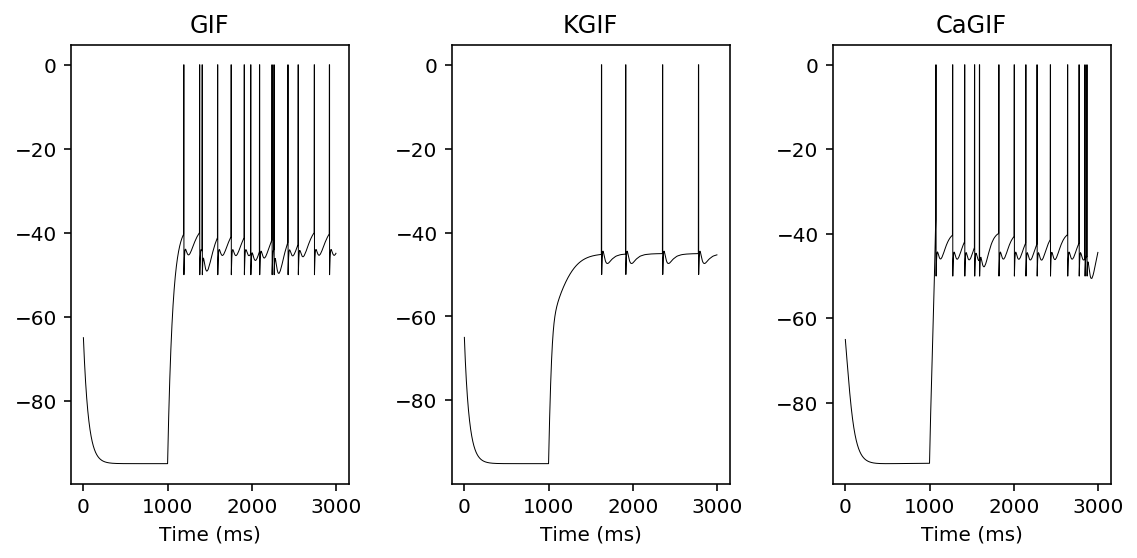

In [4]:
t_input_start = 1000.
current_step = np.concatenate((-0.03 * np.ones(int(t_input_start/dt)), 0.027 * np.ones(20000)))

plt.figure(figsize = (8, 4))

for i, key in enumerate(mods.keys()):
    plt.subplot(1, len(mods), i + 1)
    plt.title(key)
    t, V, eta, V_T, spks = mods[key].simulate(current_step, mods[key].El)
    plt.plot(t, V, 'k-', lw = 0.5)
    plt.xlabel('Time (ms)')
    
plt.tight_layout()
plt.show()

Looks like the combination of the double exponential AHP and moving threshold is most important for burst-like firing, rather than the presence/absence of $I_T$. Interestingly, the interaction of these two elements seems to produce bust firing in the CaGIF and KGIF moreso than the GIF.

## Effect of active conductances on spike latency

The main effect of $I_A$ vs. $I_T$ seems to be to modulate the latency to the first spike in response to an input pulse. The following simulations get at this idea directly.

In [5]:
no_reps = 500
no_spktrains_to_save = 20

spktrains = {}
latencies = {}

for key in mods.keys():
    
    spktrains[key] = []
    latencies[key] = []
    
    for i in range(no_reps):
        print '\rSimulating {} spiketrains {:.1f}%'.format(key, 100 * (i + 1) / no_reps),
        spks = mods[key].simulate(current_step, mods[key].El)[4]
        latencies[key].append(spks[0] - t_input_start)
        
        if i < 20:
            spktrains[key].append(spks)
    print '\nDone!'
    
    latencies[key] = np.array(latencies[key])

Simulating GIF spiketrains 100.0%      
Done!
Simulating KGIF spiketrains 100.0%         
Done!
Simulating CaGIF spiketrains 100.0%               
Done!


In [6]:
def plot_spiketrains(spktrains, ax = None, **kwargs):
    """Throwaway function to make a quick raster plot given a list of spike times.
    
    kwargs are passed to plt.plot
    """
    if ax is None:
        ax = plt.gca()
        
    for i, spktrain in enumerate(spktrains):
        plt.plot(spktrain, i * np.ones_like(spktrain), '|', **kwargs)

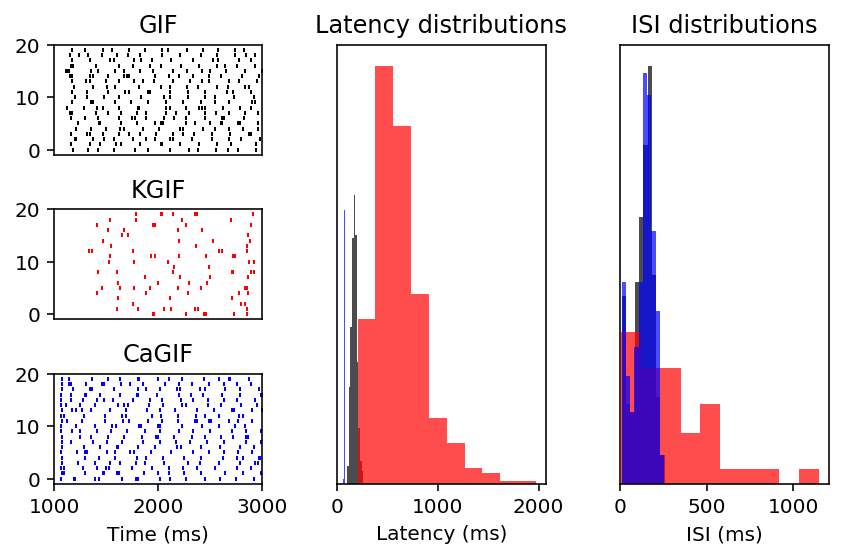

In [7]:
color_scheme = {
    'GIF': 'k',
    'KGIF': 'r',
    'CaGIF': 'b'
}

latency_fig = plt.figure()

lat_dist_spec = gs.GridSpec(1, 3, figure = latency_fig)
raster_spec = gs.GridSpecFromSubplotSpec(3, 1, lat_dist_spec[:, 0], hspace = 0.5)

# Make raster plots.
for i, key in enumerate(mods.keys()):
    plt.subplot(raster_spec[i, :])
    plt.title(key)
    plot_spiketrains(spktrains[key], color = color_scheme[key], markersize = 2)
    plt.xlim(t_input_start, len(current_step) * dt)
    
    if i != len(mods) - 1:
        plt.xticks([])
    else:
        plt.xlabel('Time (ms)')

# Make plot of latencies to first spike.
plt.subplot(lat_dist_spec[:, 1])
plt.title('Latency distributions')
for key in mods.keys():
    plt.hist(
        latencies[key], color = color_scheme[key], 
        alpha = 0.7, label = key
    )
    
plt.yticks([])
plt.xlim(0, plt.xlim()[1])
plt.xlabel('Latency (ms)')
#plt.legend()

# Make plot of ISI distributions.
plt.subplot(lat_dist_spec[:, 2])
plt.title('ISI distributions')
for key in mods.keys():
    plt.hist(
        np.concatenate([np.diff(st) for st in spktrains[key]]), 
        color = color_scheme[key], alpha = 0.7, label = key
    )
  
plt.yticks([])
plt.xlim(0, plt.xlim()[1])
plt.xlabel('ISI (ms)')
#plt.legend()

plt.tight_layout()
plt.show()

Clearly, $I_A$ and $I_T$ modulate the latency to the first spike in opposite directions. Meanwhile, only $I_A$ strongly changes the overall firing statistics.

Based on some experiments, I have a hunch that $I_T$ may make the latency relatively invariant to the preceding voltage (ie, it would drastically shorten the effective time constant). I'll try that next.

In [8]:
no_reps = 200

test_ampli = 0.03
prepulse_amplis = np.linspace(-0.03, 0.02, 20)

current_steps = np.array(
    [np.concatenate(
        (pre_ampli * np.ones(int(t_input_start/dt)), test_ampli * np.ones(20000))
    ) for pre_ampli in prepulse_amplis]
).T

sample_traces = {}
Vdep_latencies = {}

for key in mods.keys():
    
    sample_traces[key] = []
    Vdep_latencies[key] = []
    
    for i in range(current_steps.shape[1]):
        
        print '\rGenerating {} spikes {:.1f}%'.format(key, 100 * (i + 1) / current_steps.shape[1]),
        
        Vdeplats_tmp = []
        
        for j in range(no_reps):
            t, V, _, _, spks = mods[key].simulate(current_steps[:, i], mods[key].El)

            # Save a sample trace for each input strength.
            if j == 0:
                sample_traces[key].append(np.array([t, current_steps[:, i], V]).T)
            
            # Save latency, as long as first spike was after the start of the test current.
            if spks[0] > t_input_start:
                Vdeplats_tmp.append(spks[0] - t_input_start)
        
        Vdep_latencies[key].append(Vdeplats_tmp)
        
    sample_traces[key] = np.array(sample_traces[key])
    
    print '\nDone!'

Generating GIF spikes 100.0%                  
Done!
Generating KGIF spikes 100.0%                  
Done!
Generating CaGIF spikes 100.0%                  
Done!


The following figure provides a sketch of the experiment used to understand how voltage history affects latency to the first spike.

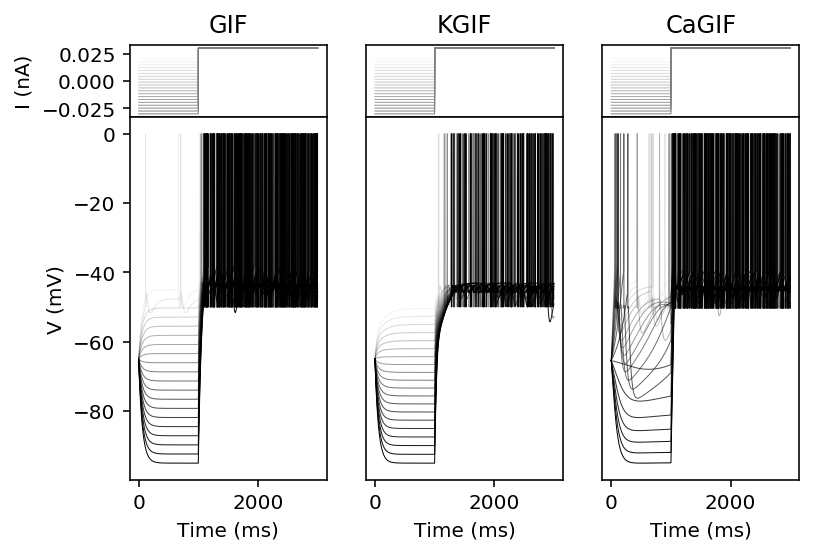

In [9]:
plt.figure()

vdeplats_tr_spec = gs.GridSpec(2, len(mods), height_ratios = [0.2, 1], hspace = 0)

for i, key in enumerate(mods.keys()):
    
    I_ax_tmp = plt.subplot(vdeplats_tr_spec[0, i])
    plt.title(key)
    plt.xticks([])
    
    V_ax_tmp = plt.subplot(vdeplats_tr_spec[1, i])
    
    for j in range(sample_traces[key].shape[0]):
        I_ax_tmp.plot(
            sample_traces[key][j, :, 0], sample_traces[key][j, :, 1],
            '-', lw = 0.5, color = 'gray', alpha = (sample_traces[key].shape[0] - j) / sample_traces[key].shape[0]
        )
        
        V_ax_tmp.plot(
            sample_traces[key][j, :, 0], sample_traces[key][j, :, 2],
            '-', lw = 0.5, color = 'k', alpha = (sample_traces[key].shape[0] - j) / sample_traces[key].shape[0]
        )
        
    if i != 0:
        I_ax_tmp.set_yticks([])
        V_ax_tmp.set_yticks([])
    else:
        I_ax_tmp.set_ylabel('I (nA)')
        V_ax_tmp.set_ylabel('V (mV)')
        
    V_ax_tmp.set_xlabel('Time (ms)')
        
plt.show()
    

/Users/eharkin/miniconda3/envs/pozz/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/eharkin/miniconda3/envs/pozz/lib/python2.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/eharkin/miniconda3/envs/pozz/lib/python2.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/eharkin/miniconda3/envs/pozz/lib/python2.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/eharkin/miniconda3/envs/pozz/lib/python2.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


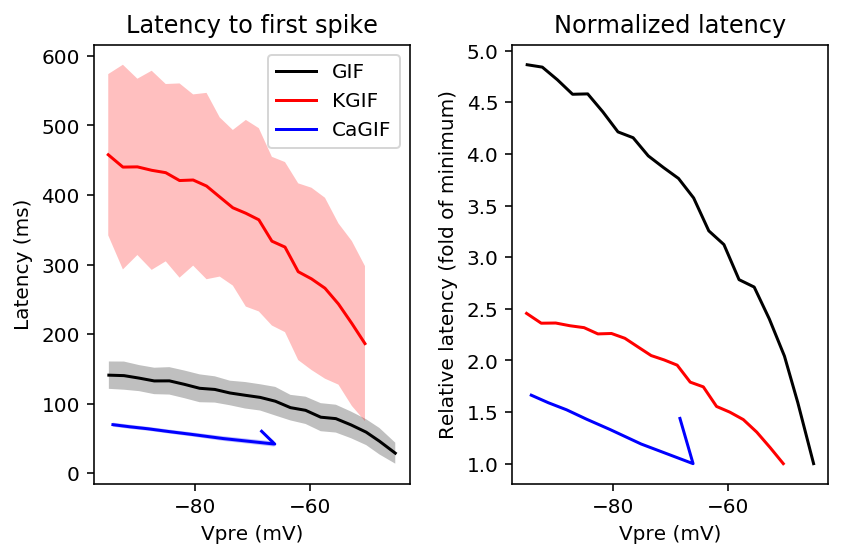

In [10]:
plt.figure()

raw_ax = plt.subplot(121)
plt.title('Latency to first spike')
normed_ax = plt.subplot(122)
plt.title('Normalized latency')

for key in mods.keys():
    V_pre_tmp = sample_traces[key][:, int(t_input_start /dt ) - 1, 2]
    mean_latencies_tmp = np.array([np.mean(lats) for lats in Vdep_latencies[key]])
    std_latencies_tmp = np.array([np.std(lats) for lats in Vdep_latencies[key]])
    
    raw_ax.fill_between(
        V_pre_tmp, 
        mean_latencies_tmp - std_latencies_tmp, mean_latencies_tmp + std_latencies_tmp,
        edgecolor = 'none', facecolor = color_scheme[key], alpha = 0.25
    )
    raw_ax.plot(V_pre_tmp, mean_latencies_tmp, '-', color = color_scheme[key], label = key)
    
    normed_ax.plot(
        V_pre_tmp, mean_latencies_tmp / np.nanmin(mean_latencies_tmp), 
        '-', color = color_scheme[key], label = key
    )
    
raw_ax.set_xlabel('Vpre (mV)')
raw_ax.set_ylabel('Latency (ms)')
raw_ax.legend()

normed_ax.set_ylabel('Relative latency (fold of minimum)')
normed_ax.set_xlabel('Vpre (mV)')

plt.tight_layout()

plt.show()

For a given input, the CaGIF produces very short latencies across a wide range of prepulse voltages. Surprisingly, both $I_A$ and $I_T$ seem to reduce the dependence of latency on the pre-pulse voltage (right). (This could be because the shortest latency for the KGIF is still pretty long.)

## Encoding in-vivo-like inputs

Finally, the main event. Apply OU noise stimulus to candidate SOM models and examine how well the input is represented in population spiketrains using cross spectra etc.

### Perform simulations

We'll need some pretty long simulations to get decent estimates of the cross spectra. First we'll do those in batch and reuse the population spiketrains/input throughout this section.

In [11]:
no_reps = 400
T = 2**18
input_noise = generateOUprocess(T, 2., 0.005, 0.100, dt, 42)

spkvecs = {}
freqfilt_sample_traces = {}

for key in mods.keys():
    
    spkvecs[key] = np.zeros_like(input_noise, dtype = np.float64)

    for i in range(no_reps):
        print '\rSimulating {} {:.1f}%'.format(key, 100 * (i + 1) / no_reps),
        t, V, eta, V_T, spks = mods[key].simulate(input_noise, -50.)
        spkvecs[key] += timeToIntVec(spks, T, dt)
        
        if i == 0:
            freqfilt_sample_traces[key] = np.array([t, input_noise, V]).T

    print '\nDone!'
    
    spkvecs[key] /= no_reps

    print '{} mean firing rate: {:.1f}Hz\n'.format(key, len(spks)/(T * 1e-3))

Simulating GIF 100.0%                                                                                                                                                                                                                                                        
Done!
GIF mean firing rate: 4.4Hz

Simulating KGIF 100.0%                                                                                                                                                                                                                                                                                                                                                                                                              
Done!
KGIF mean firing rate: 1.3Hz

Simulating CaGIF 100.0%                                                                                                                                                                                                                       

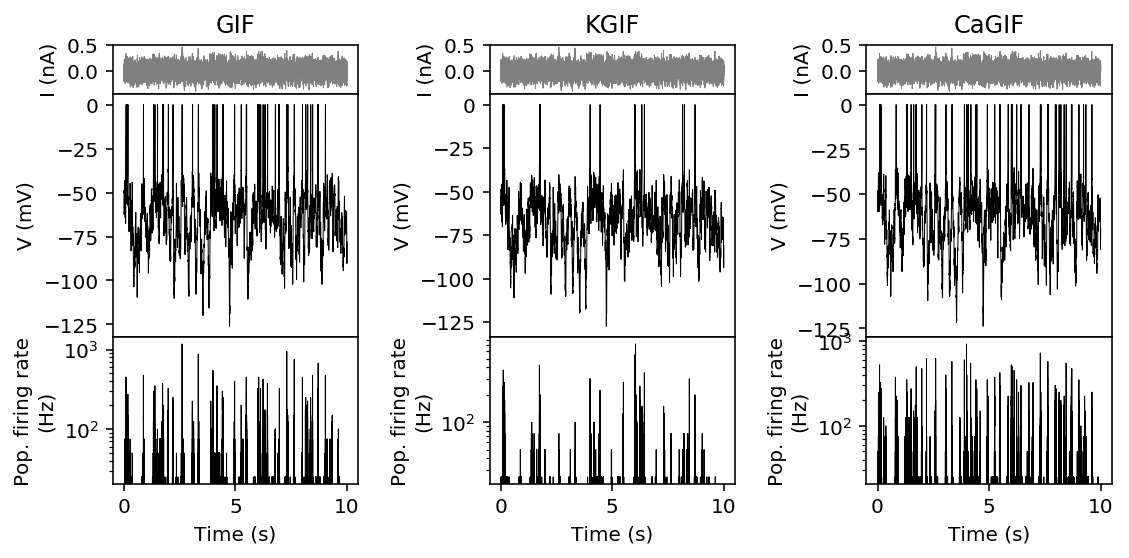

In [12]:
#Plot first 10s.

plt.figure(figsize = (8, 4))

freqfilt_spec_outer = gs.GridSpec(1, len(mods))

for i, key in enumerate(mods.keys()):
    
    freqfilt_spec_tmp = gs.GridSpecFromSubplotSpec(
        3, 1, freqfilt_spec_outer[:, i], 
        height_ratios = [0.2, 1, 0.6], hspace = 0
    )

    plt.subplot(freqfilt_spec_tmp[0, :])
    plt.title(key)
    plt.plot(
        (freqfilt_sample_traces[key][:, 0] * 1e-3)[:int(10000/dt)], 
        freqfilt_sample_traces[key][:, 1][:int(10000/dt)], 
        '-', color = 'gray', lw = 0.5
    )
    plt.ylabel('I (nA)')
    plt.xticks([])

    plt.subplot(freqfilt_spec_tmp[1, :])
    plt.plot(
        (freqfilt_sample_traces[key][:, 0] * 1e-3)[:int(10000/dt)], 
        freqfilt_sample_traces[key][:, 2][:int(10000/dt)], 
        'k-', lw = 0.5
    )
    plt.ylabel('V (mV)')
    plt.xticks([])

    plt.subplot(freqfilt_spec_tmp[2, :])
    plt.semilogy(
        (freqfilt_sample_traces[key][:, 0] * 1e-3)[:int(10000/dt)], 
        spkvecs[key][:int(10000/dt)] / (1e-3 * dt),
        'k-', lw = 0.5
    )
    plt.ylabel('Pop. firing rate\n(Hz)')
    plt.xlabel('Time (s)')

freqfilt_spec_outer.tight_layout(plt.gcf())
    
plt.show()

GIF, KGIF, and CaGIF all receive the same input. CaGIF spikes more because it's more excitable, while KGIF correspondingly spikes less. All neurons in the "population" are identical, so we see big spikes in population rate even without binning.

### How well do GIF/KGIF/CaGIF encode different input freqs?

Working hypothesis is that CaGIF could better encode high frequencies.

In [13]:
def SR_coherence(spktrain, input_signal, dt, method = 'welch'):
    """Compute the cross spectrum between a spiketrain and the corresponding input.
    Spiketrain can be a population spiketrain.
    """
    
    if method == 'raw':
        Y = np.fft.rfft(spktrain)[1:]/len(spktrain)
        X = np.fft.rfft(input_signal)[1:]/len(spktrain)
        # Note: Would be correct to multiply both by 2/N, but obviously these cancel in the num and denom.

        coherence = np.absolute(Y * X.conj()) / np.absolute(X)**2
        freqs = np.fft.rfftfreq(len(spktrain), 1e-3 * dt)[1:] # Convert dt from ms to s.
        
    elif method == 'welch':
        _, numerator = csd(
            spktrain, input_signal, 
            fs = 1e4, nperseg = 2**14, detrend = False,
            return_onesided = True, scaling = 'spectrum'
        )
        freqs, denominator = csd(
            spktrain, spktrain,
            fs = 1e4, nperseg = 2**14, detrend = False,
            return_onesided = True, scaling = 'spectrum'
        )
        
        coherence = np.absolute(numerator)/denominator
    
    return coherence, freqs

**Note:** Power terms from `scipy.signal.csd(X, X)` are *not* equivalent to `np.absolute(np.fft.rfft(X))**2`. This is partly because of unintuitive behaviour of `np.fft.rfft`. 

The numpy function simply returns the positive frequency terms computed according to $\tilde{X}_f = \sum_{n=0}^N X_n \exp[-2 \pi i \frac{fn}{N}]$, where $f$ is a frequency, $N$ is the number of samples, and $X_n$ is the amplitude of a real signal at sample $n$. This means that the amplitude of a sine wave of frequency $f$ in $X$ would be given by $\frac{2}{N} \mid \tilde{X}_f \mid$ for $f \neq 0$. (Since negative frequency terms are simply discarded, all nonzero frequency terms have to be doubled.)

In contrast, `scipy.signal.csd` handles doubling and normalization of positive frequency terms internally (in addition to doing other stuff).

In [14]:
burn_in = 1000 # Period at the start of the experiment to ignore to reduce initialization effects.
coherences = {}

for key in mods.keys():
    coh, f = SR_coherence(spkvecs[key][burn_in:], input_noise[burn_in:], dt * 1e-3, method = 'welch')
    coherences[key] = np.array([f, coh]).T

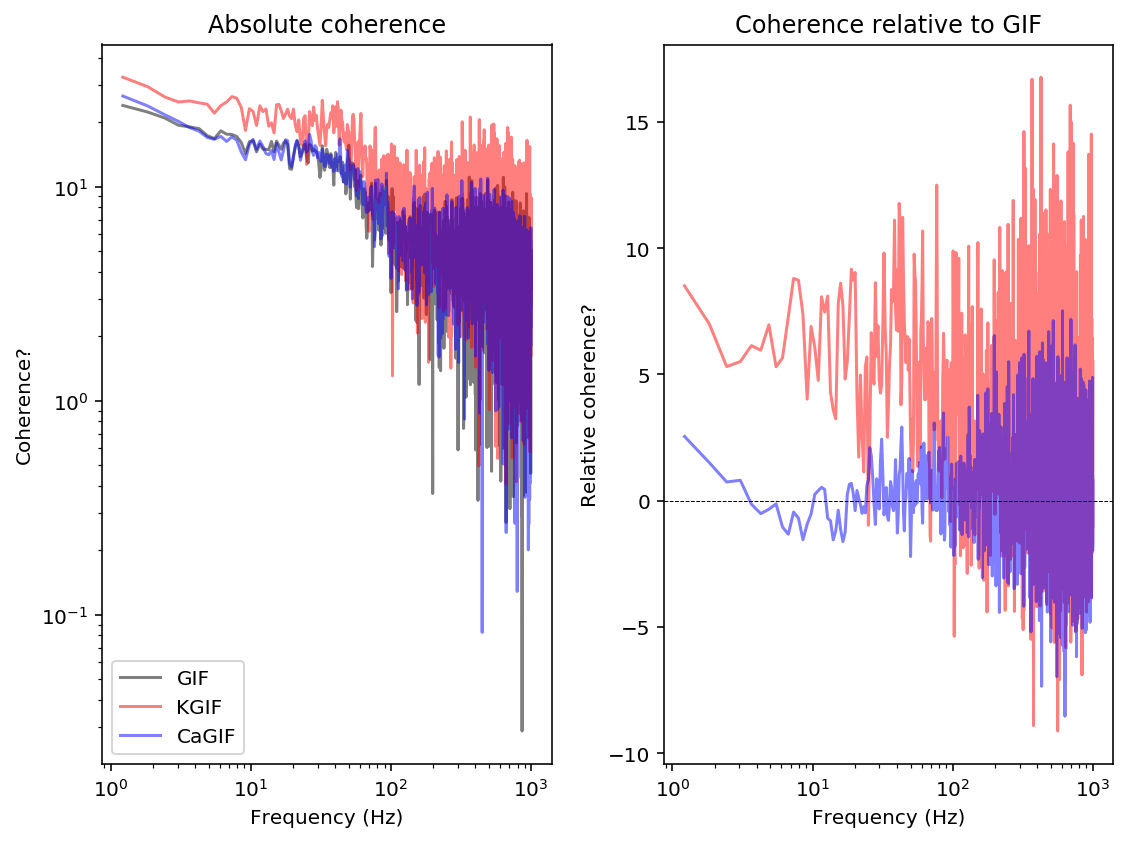

In [15]:
freqrange = (1., 1000.)

plt.figure(figsize = (8, 6))
coh_ax = plt.subplot(121)
coh_ax.set_title('Absolute coherence')
coh_ax.set_xlabel('Frequency (Hz)')
coh_ax.set_ylabel('Coherence?')

rel_coh_ax = plt.subplot(122)
rel_coh_ax.set_title('Coherence relative to GIF')
rel_coh_ax.set_xlabel('Frequency (Hz)')
rel_coh_ax.set_ylabel('Relative coherence?')

for i, key in enumerate(mods.keys()):
    
    lowind = np.argmin(np.abs(coherences[key][:, 0] - freqrange[0]))
    hiind = np.argmin(np.abs(coherences[key][:, 0] - freqrange[1]))
    
    coh_ax.loglog(
        coherences[key][lowind:hiind, 0], 
        coherences[key][lowind:hiind, 1], 
        '-', color = color_scheme[key], alpha = 0.5,
        label = key
    )
    
    if key != 'GIF':
        rel_coh_ax.semilogx(
            coherences[key][lowind:hiind, 0], 
            coherences[key][lowind:hiind, 1] - coherences['GIF'][lowind:hiind, 1], 
            '-', color = color_scheme[key], alpha = 0.5,
            label = key
        )

coh_ax.legend()

rel_coh_ax.axhline(0, color = 'k', ls = '--', lw = 0.5)
    
plt.tight_layout()
plt.show()

Looks like the KGIF is better across the board! This may be because $I_A$ exaggerates the stochasticity of spiking for a given threshold width $\Delta V$ (remember that spikes are generated according to a Poisson process with rate $\lambda = \lambda_0 \exp \left[ \frac{V(t) - V_T(t)}{\Delta V} \right]$, where $V_T(t)$ is the moving threshold).

I expected that the CaGIF would be better than the KGIF/GIF for higher frequencies, so the above result is surprising.

### Does the CaGIF better encode the gradient of the input?

Maybe the CaGIF could efficiently encode the gradient of the input by triggering bursts when the membrane depolarizes rapidly.

In [16]:
diff_coherences = {}

for key in mods.keys():
    coh, f = SR_coherence(spkvecs[key][burn_in:-1], np.diff(input_noise[burn_in:]), dt * 1e-3, method = 'welch')
    diff_coherences[key] = np.array([f, coh]).T

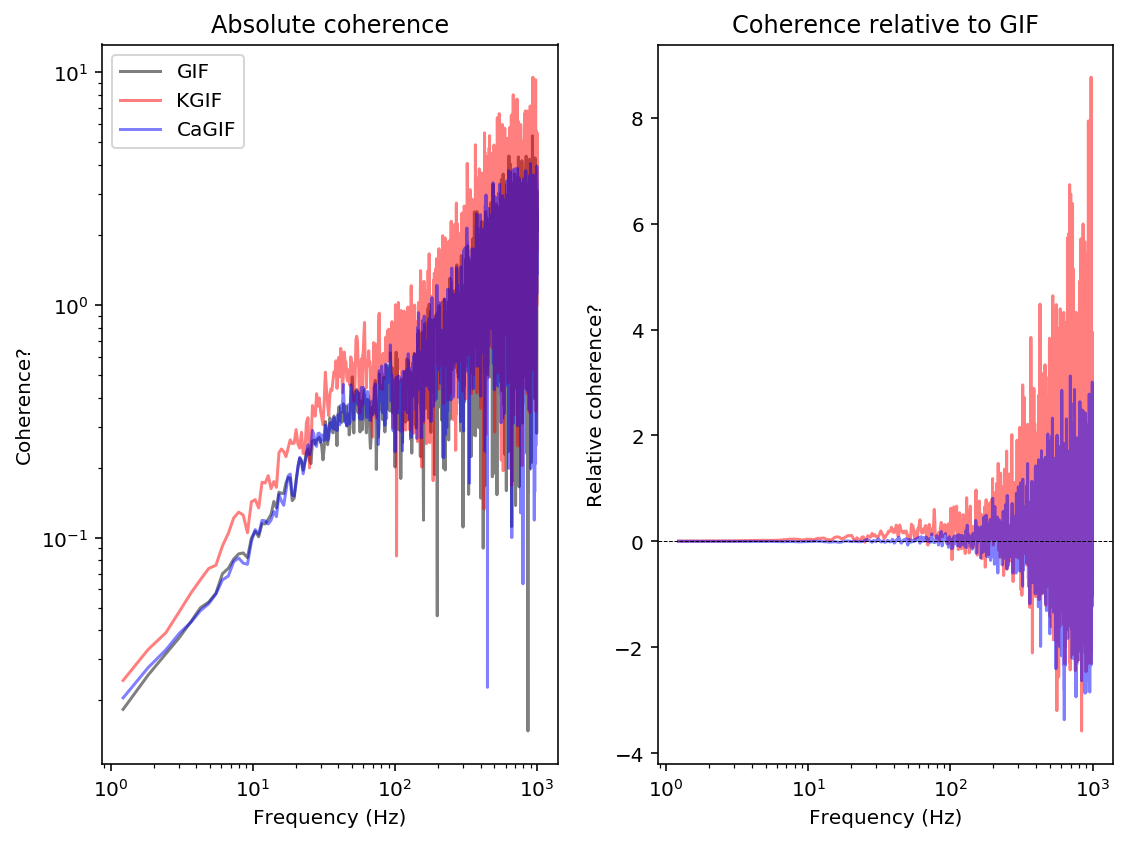

In [17]:
freqrange = (1., 1000.)

plt.figure(figsize = (8, 6))
coh_ax = plt.subplot(121)
coh_ax.set_title('Absolute coherence')
coh_ax.set_xlabel('Frequency (Hz)')
coh_ax.set_ylabel('Coherence?')

rel_coh_ax = plt.subplot(122)
rel_coh_ax.set_title('Coherence relative to GIF')
rel_coh_ax.set_xlabel('Frequency (Hz)')
rel_coh_ax.set_ylabel('Relative coherence?')

for i, key in enumerate(mods.keys()):
    
    lowind = np.argmin(np.abs(diff_coherences[key][:, 0] - freqrange[0]))
    hiind = np.argmin(np.abs(diff_coherences[key][:, 0] - freqrange[1]))
    
    coh_ax.loglog(
        diff_coherences[key][lowind:hiind, 0], 
        diff_coherences[key][lowind:hiind, 1], 
        '-', color = color_scheme[key], alpha = 0.5,
        label = key
    )
    
    if key != 'GIF':
        rel_coh_ax.semilogx(
            diff_coherences[key][lowind:hiind, 0], 
            diff_coherences[key][lowind:hiind, 1] - diff_coherences['GIF'][lowind:hiind, 1], 
            '-', color = color_scheme[key], alpha = 0.5,
            label = key
        )

coh_ax.legend()

rel_coh_ax.axhline(0, color = 'k', ls = '--', lw = 0.5)
    
plt.tight_layout()
plt.show()

Surprisingly, looks like the KGIF is better than the CaGIF again! The CaGIF doesn't even seem to be better than the GIF, which is strange.

Possible explanations:
- CaGIF doesn't reliably generate bursts in response to rapidly rising inputs. Could be "fixed" by changing params.
- Bursting mechanism asymmetrically supports encoding rising and falling derivatives, cancelling out any effect.

### Does calcium support encoding positive input gradients?

Obviously, $I_T$ enhances spiking in reponse to rising inputs. Maybe this means that CaGIF differentially supports encoding positive vs. negative derivatives. This might mean that CaGIFs are better to encode the onset of a stimulus than changes of either sign.

In [18]:
posdiff_coherences = {}

for key in mods.keys():
    coh, f = SR_coherence(
        spkvecs[key][burn_in:-1], 
        np.clip(np.diff(input_noise[burn_in:]), a_min = 0, a_max = None), 
        dt * 1e-3, method = 'welch'
    )
    posdiff_coherences[key] = np.array([f, coh]).T

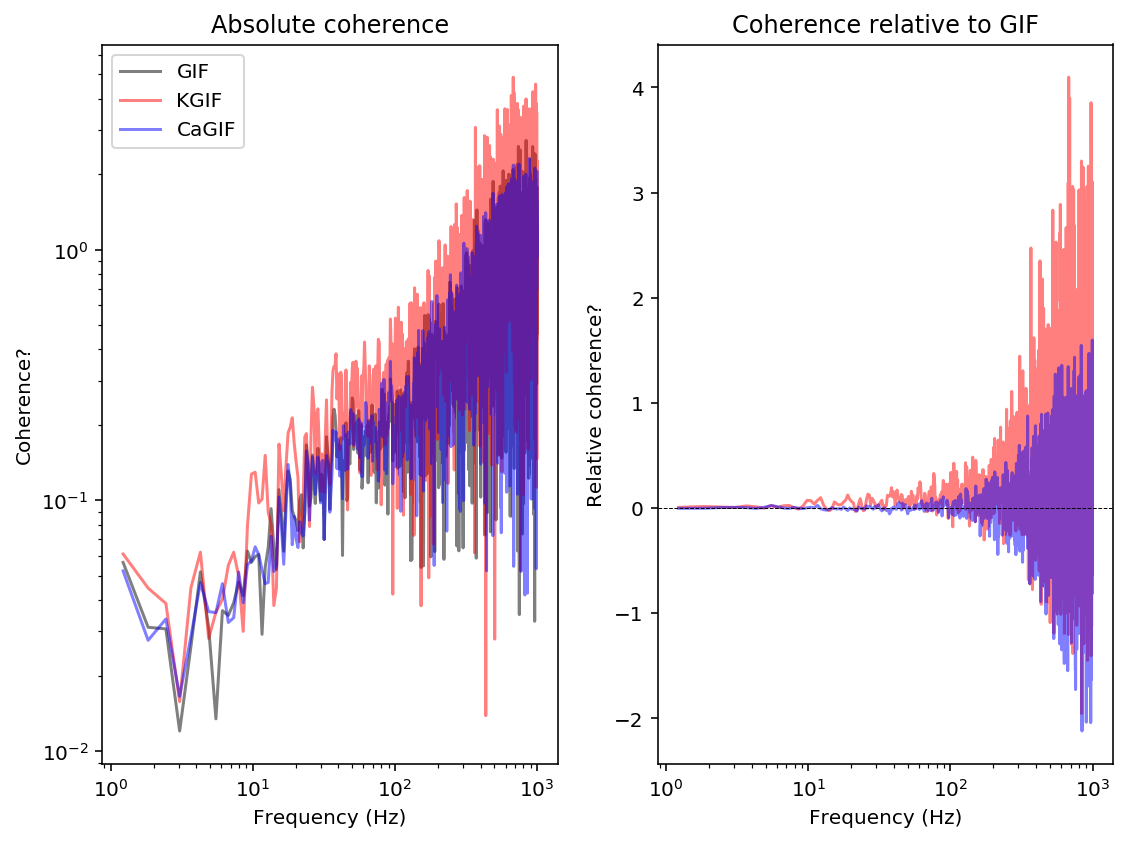

In [19]:
freqrange = (1., 1000.)

plt.figure(figsize = (8, 6))
coh_ax = plt.subplot(121)
coh_ax.set_title('Absolute coherence')
coh_ax.set_xlabel('Frequency (Hz)')
coh_ax.set_ylabel('Coherence?')

rel_coh_ax = plt.subplot(122)
rel_coh_ax.set_title('Coherence relative to GIF')
rel_coh_ax.set_xlabel('Frequency (Hz)')
rel_coh_ax.set_ylabel('Relative coherence?')

for i, key in enumerate(mods.keys()):
    
    lowind = np.argmin(np.abs(posdiff_coherences[key][:, 0] - freqrange[0]))
    hiind = np.argmin(np.abs(posdiff_coherences[key][:, 0] - freqrange[1]))
    
    coh_ax.loglog(
        posdiff_coherences[key][lowind:hiind, 0], 
        posdiff_coherences[key][lowind:hiind, 1], 
        '-', color = color_scheme[key], alpha = 0.5,
        label = key
    )
    
    if key != 'GIF':
        rel_coh_ax.semilogx(
            posdiff_coherences[key][lowind:hiind, 0], 
            posdiff_coherences[key][lowind:hiind, 1] - posdiff_coherences['GIF'][lowind:hiind, 1], 
            '-', color = color_scheme[key], alpha = 0.5,
            label = key
        )

coh_ax.legend()

rel_coh_ax.axhline(0, color = 'k', ls = '--', lw = 0.5)
    
plt.tight_layout()
plt.show()

Doesn't look like the CaGIF has any advantages over the GIF or KGIF, even when only positive input gradients are considered.

### Does the calcium current affect phase shift?

One last try to find a distinctive feature of the CaGIF. At the very least, the latency-shortening effect of $I_T$ should show up as a reduction in phase delay between the current input and spiketrain output.

In [20]:
def phase_delay(spktrain, input_signal, nperseg = 2**14, dt = 0.1):
    """Compute the average phase delay between the spktrain and input_signal.
    
    Values range from [-pi, pi] in radians, with positive values indicating lagged spikes.
    Phase shifts are calculated over slices of length nperseg and averaged.
    """
    
    # Reshape arrays for vectorized fft.
    # Discards data *at beginning* that doesn't fit neatly into nperseg-sized chunks.
    spktrain = spktrain[(len(spktrain)%nperseg):].reshape((len(spktrain)//nperseg, nperseg))
    input_signal = input_signal[(len(input_signal)%nperseg):].reshape((len(input_signal)//nperseg, nperseg))
    
    spktrain_terms = np.fft.rfft(spktrain, axis = 1)[:, 1:] # Remove zero freq term from all rfft outputs.
    input_terms = np.fft.rfft(input_signal, axis = 1)[:, 1:]
    
    phase_delay_ = np.mean(np.angle(spktrain_terms) - np.angle(input_terms), axis = 0)
    
    freqs = np.fft.rfftfreq(nperseg, 1e-3 * dt)[1:] # Convert dt from ms to s.
    
    return phase_delay_, freqs

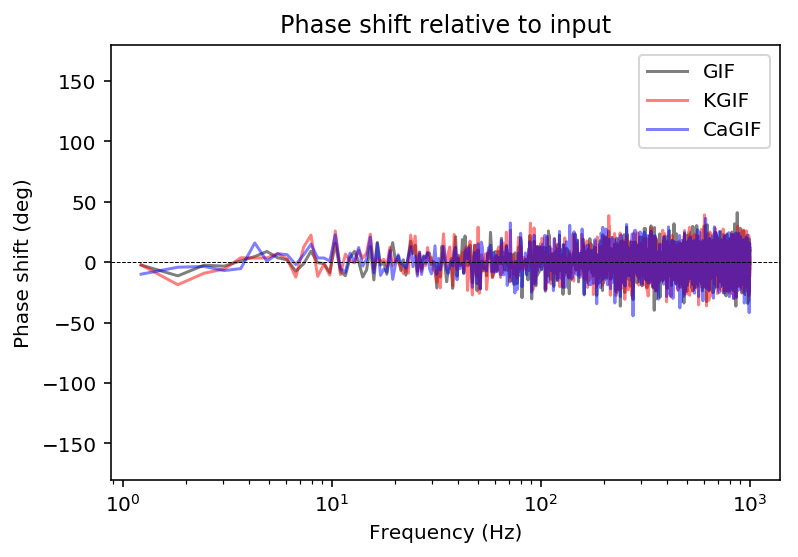

In [21]:
freqrange = (1., 1000.)

plt.figure()

plt.subplot(111)
plt.title('Phase shift relative to input')

for key in mods.keys():
    
    # Compute phase delays.
    phase_delays_, freqs = phase_delay(spkvecs[key][burn_in:], input_noise[burn_in:])
    
    # Compute indices to plot.
    lowind = np.argmin(np.abs(freqs - freqrange[0]))
    hiind = np.argmin(np.abs(freqs - freqrange[1]))
    
    plt.semilogx(
        freqs[lowind:hiind], phase_delays_[lowind:hiind] * 180. / np.pi, # Convert phase shift to degrees.
        '-', color = color_scheme[key], label = key, alpha = 0.5
    )
    
plt.axhline(0, color = 'k', ls = '--', lw = 0.5)
plt.ylim(-180., 180.)
plt.ylabel('Phase shift (deg)')
plt.xlabel('Frequency (Hz)')
plt.legend()
    
plt.show()

Positive phase shifts indicate delayed firing relative to the input.

I expected $I_T$ in the CaGIF to cause a phase advance, leading to a smaller lag than the GIF or KGIF. This doesn't seem to be the case. It's possible that with longer simulations it would be possible to see an effect that's currently buried in the noise, but a change in phase shift of <10deg is probably not interesting.

Maybe there's an effect on the phase shift with respect to the gradient of the input?

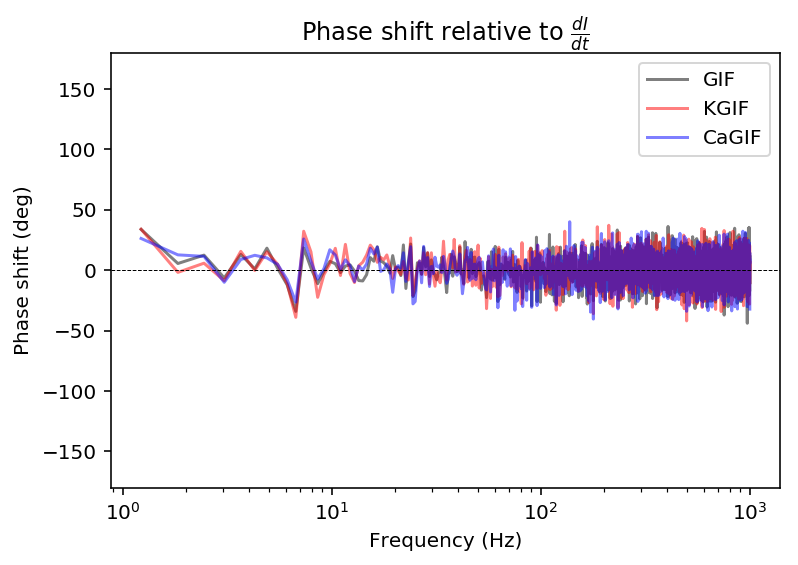

In [22]:
freqrange = (1., 1000.)

plt.figure()

plt.subplot(111)
plt.title(r'Phase shift relative to $\frac{dI}{dt}$')

for key in mods.keys():
    
    # Compute phase delays.
    phase_delays_, freqs = phase_delay(spkvecs[key][burn_in:-1], np.diff(input_noise[burn_in:]))
    
    # Compute indices to plot.
    lowind = np.argmin(np.abs(freqs - freqrange[0]))
    hiind = np.argmin(np.abs(freqs - freqrange[1]))
    
    plt.semilogx(
        freqs[lowind:hiind], phase_delays_[lowind:hiind] * 180. / np.pi, # Convert phase shift to degrees.
        '-', color = color_scheme[key], label = key, alpha = 0.5
    )
    
plt.axhline(0, color = 'k', ls = '--', lw = 0.5)
plt.ylim(-180., 180.)
plt.ylabel('Phase shift (deg)')
plt.xlabel('Frequency (Hz)')
plt.legend()
    
plt.show()

Doesn't look like $I_T$ affects the spktrain phase shift with respect to the gradient of the input.

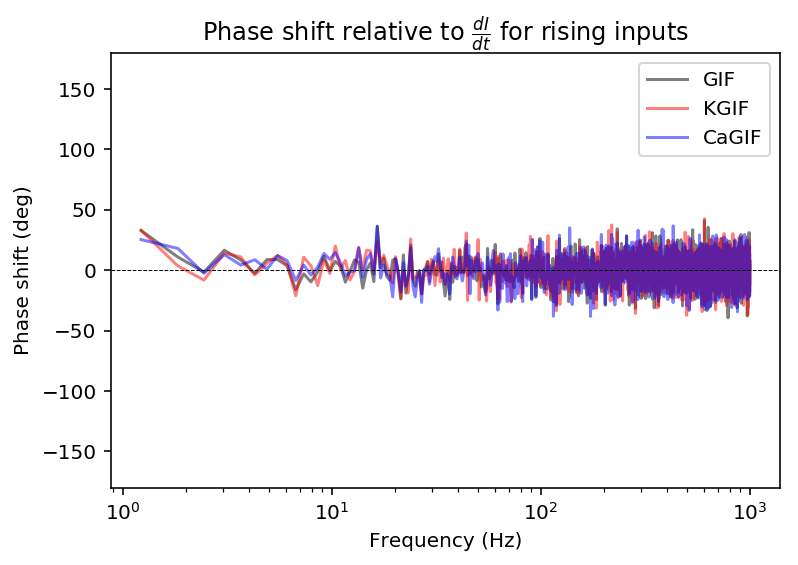

In [23]:
freqrange = (1., 1000.)

plt.figure()

plt.subplot(111)
plt.title(r'Phase shift relative to $\frac{dI}{dt}$ for rising inputs')

for key in mods.keys():
    
    # Compute phase delays.
    phase_delays_, freqs = phase_delay(
        spkvecs[key][burn_in:-1], 
        np.clip(np.diff(input_noise[burn_in:]), a_min = 0, a_max = None)
    )
    
    # Compute indices to plot.
    lowind = np.argmin(np.abs(freqs - freqrange[0]))
    hiind = np.argmin(np.abs(freqs - freqrange[1]))
    
    plt.semilogx(
        freqs[lowind:hiind], phase_delays_[lowind:hiind] * 180. / np.pi, # Convert phase shift to degrees.
        '-', color = color_scheme[key], label = key, alpha = 0.5
    )
    
plt.axhline(0, color = 'k', ls = '--', lw = 0.5)
plt.ylim(-180., 180.)
plt.ylabel('Phase shift (deg)')
plt.xlabel('Frequency (Hz)')
plt.legend()
    
plt.show()

Doesn't look like $I_T$ reduces phase shift for rapidly rising inputs.

What about a sort of weighted phase shift? We could write $$ \bar{\Delta \theta} =  \sum_{i \in \{f\}} \frac{\Delta \theta_i}{\pi i} w_i, $$ where $\{f\}$ is the set of frequencies extracted from a real signal $X$ using a DFT, $\Delta \theta_i$ is the phase shift in radians at a particular frequency, and $w_i = \frac{\lvert \tilde{X}_i \rvert ^2}{\sum_{j \in \{f\}} \lvert \tilde{X}_j \rvert^2}$ is the fraction of the total power that is at frequency $i$. This would give us $\bar{\Delta \theta}$ a weighted phase shift for all frequencies in units of seconds.